# Tutorial to run the variable-coefficient KdV (vKdV) model

This tutorial gives a background on running the vKdV model to track the evolution of an internal wave in an ocean with continuous density stratification. The model equation is

$$
\frac{\partial A}{\partial t} + c(x) \frac{\partial A}{\partial x} + \alpha(x) A \frac{\partial A}{\partial x} +\beta(x) \frac{\partial^3 A}{\partial x^3}
+ \frac{c(x)}{2Q(x)}\frac{\partial Q}{\partial x}A\ = 0
$$

where the solution $A(x,t)$ is the wave amplitude (roughly the displacement of an isopycnal within the pycnocline for a mode-1 internal wave).

How to:
  - Create initial stratification and bathymetry
  - Initialise a `KdV` class
  - Inspect the KdV parameters
  - Specifify boundary conditions
  - Run a model
  - Inspect the results
  
---

Matt Rayson

University of Western Australia

March 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iwaves.kdv.vkdv import  vKdV as KdV

In [2]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14

# Specify the horizontal domain and create a bathymetry section

We use an analytical profile of a smooth shelf break represented with a tanh function.

In [3]:
def depth_tanh(beta, x):
    """
    Hyperbolic tangent shelf break

    H - total depth
    h0 - shelf height
    x0 - shelf break x location
    lt - shelf break width
    """
    
    H, h0, x0, lt = beta

    return H-0.5*h0*(1+np.tanh((x-x0)/(0.5*lt)))

(-2000.0, 0.0)

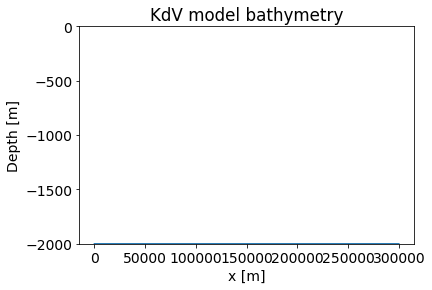

In [4]:
# Model parameters
N = 3000 # Number of grid points
dx = 100. # horizontal grid spacing

H = 2000
h0 = 0
bathy_params = [H, h0, 75e3, 70e3]  # See the depth_tanh function for the mean

# The horizontal domain
x = np.arange(0, N*dx, dx)

# The depth
h = depth_tanh(bathy_params, x) 

plt.figure()
plt.plot(x, -h)
plt.title('KdV model bathymetry')
plt.ylabel('Depth [m]')
plt.xlabel('x [m]')
plt.ylim(-H, 0)

# Specify the vertical density profile

We use a double hyperbolic tangent to represent density profile. This is a good approximation for some regions of the upper ocean. See e.g.,

- Manderson, A, M. D. Rayson, E. Cripps, M. Girolami, J. P. Gosling, M. Hodkiewicz, N. L. Jones, G. N. Ivey, (2019) Uncertainty quantification of density and stratification estimates with implications for predicting ocean dynamics, *Journal of Atmospheric and Oceanic Technology*, [https://journals.ametsoc.org/doi/full/10.1175/JTECH-D-18-0200.1](https://journals.ametsoc.org/doi/full/10.1175/JTECH-D-18-0200.1)
- Rayson, M. D., N. L. Jones and G. N. Ivey (2019), Observations of large amplitude mode-2 nonlinear internal waves on the Australian North West Shelf, *Journal of Physical Oceanography*, [https://doi.org/10.1175/JPO-D-18-0097.1](https://doi.org/10.1175/JPO-D-18-0097.1)

## Southern ocean specific

Use a double-gaussian profile on the log of the depth



In [5]:
def rho_double_tanh(beta, z):
    """
    Double hyperbolic tangent density profile model
    """
    return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3])
        + np.tanh((z+beta[4])/beta[5]))

def double_gaussian_N2(z, beta):
    
    lnz = -np.log(np.abs(z))
    
    w1 = beta[6]
    w2 = 1-w1
    return beta[0,...] + beta[1,...] * (w1*np.exp(- ((lnz+beta[2,...])/beta[3,...])**2 )  +\
              w2*np.exp(-((lnz+beta[4,...])/beta[5,...])**2 ) )

def double_gaussian_rho(beta, z, rho0=1027.0):
    N2 = double_gaussian_N2(z, beta)
    drho_dz = N2*rho0/9.81
    dz = -np.diff(z).mean()
    return rho0 + np.cumsum(drho_dz*dz)
    
    
    

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 0, 'Density [kg m$^{-3}$]')

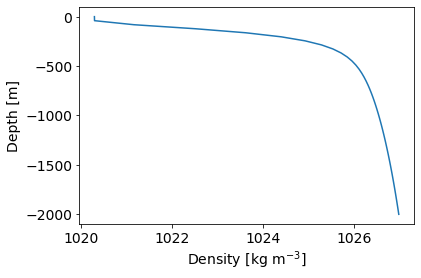

In [6]:
# See the plot_woa_stratification.ipynb notebook for derivation of these parameters
N2_SO_Mar_params = np.array([1.85e-06, 7.83e-05, 4.48e+00, 3.73e-01,
       7.17e+00, 9.72e-01, 9.17e-01])

N2_SO_Aug_params = np.array([5e-8, 1.3e-5,  5.6,  0.15,
        6.8, 0.55,  0.2])

N2_ITF_Mar_params = np.array([6.03e-07, 3.39e-04, 2.00e+00, 3.19e+00,
       4.40e+00, 9.15e-01, 1.60e-01])

N2_ITF_Aug_params = np.array([5.09e-08,  3.37e-04,  4.42e+00,  6.10e-01,
        4.88e+00,  1.06e+00,  7.55e-01])


# Number of vertical levels
Nz = 50

z = np.linspace(-H,0,Nz)
rhoz = double_gaussian_rho(N2_ITF_Mar_params,z)

plt.figure()
plt.plot(rhoz, z)
plt.ylabel('Depth [m]')
plt.xlabel('Density [kg m$^{-3}$]')

# Initialise the KdV model

This requires the density profile and bathymetric section plus a few other model inputs. This does not solve the equation; it only calculates the input parameters e.g. nonlinearity, linear phase speed.

In [7]:
# IMEX options (These are weights for the numerical time integration scheme)
imex={
        'MCN_AX2':(1/8., 3/8.),
        'AM2_AX2':(1/2., 1/2.),
        'AI2_AB3':(3/2., 5/6.),
        'BDF2_BX2':(0.,0.),
        'BDF2_BX2s':(0.,1/2.),
        'BI2_BC3':(1/3.,2/3.),
}


In [17]:

dt = 15.
mode = 0 # Mode=0 corresponds to mode-1 waves
imexscheme = 'AM2_AX2'
c_im = imex[imexscheme][0]
b_ex = imex[imexscheme][1]

kdvargs = dict(
   N=N,
   dx=dx,
   dt=dt,
   spongedist = 50e3,
   spongetime = 600.,
   Nsubset = 10,
   nonhydrostatic=1.,
   nonlinear=1.,
   c_im=c_im,
   b_ex=b_ex,
   verbose=True,
)

## Initialise the class
mykdv = KdV(rhoz, z, h, x, mode, **kdvargs)


Calculating eigenfunctions...
0.0 % complete...
5.0 % complete...
10.0 % complete...
15.0 % complete...
20.0 % complete...
25.0 % complete...
30.0 % complete...
35.0 % complete...
40.0 % complete...
45.0 % complete...
50.0 % complete...
55.0 % complete...
60.0 % complete...
65.0 % complete...
70.0 % complete...
75.0 % complete...
80.0 % complete...
85.0 % complete...
90.0 % complete...
95.0 % complete...


# Inspect the KdV model parameters

Text(0, 0.5, 'Linear amplification "Q"')

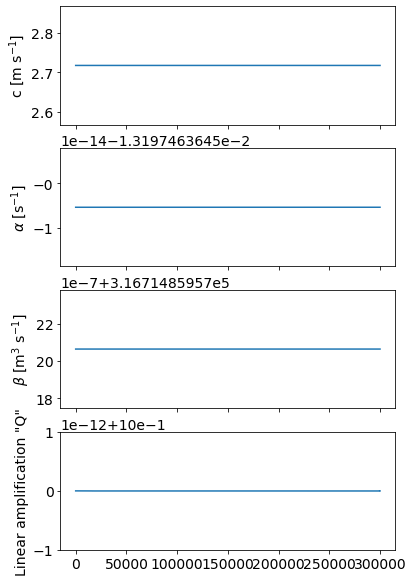

In [18]:
# Plot some of the environmental parameters as a function of distance
plt.figure(figsize=(6,10))
ax1=plt.subplot(411)
ax1.plot(mykdv.x, mykdv.c)
plt.ylabel('c [m s$^{-1}$]')
ax1.set_xticklabels([])
ax2=plt.subplot(412)
ax2.plot(mykdv.x, mykdv.alpha)
plt.ylabel(r'$\alpha$ [s$^{-1}$]')
ax2.set_xticklabels([])

ax3=plt.subplot(413)
ax3.plot(mykdv.x, mykdv.beta)
plt.ylabel(r'$\beta$ [m$^3$ s$^{-1}$]')
ax3.set_xticklabels([])

ax2=plt.subplot(414)
ax2.plot(mykdv.x, 1/mykdv.Q)
plt.ylabel(r'Linear amplification "Q"')


Text(0, 0.5, 'Depth [m]')

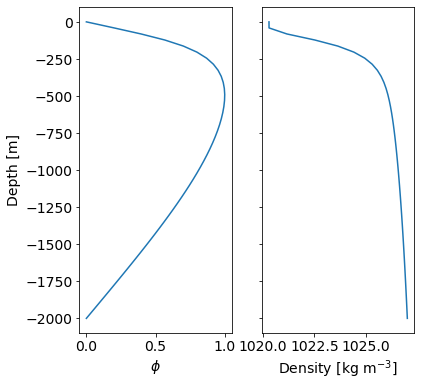

In [19]:
# Plot the density profile and vertical eigenfunction
plt.figure(figsize=(6,6))
ax1=plt.subplot(121)
ax1.plot(mykdv.Phi[:,0],mykdv.Z[:,0], )
plt.xlabel('$\phi$')

ax2=plt.subplot(122)
ax2.plot(mykdv.rhoZ[:,0],mykdv.Z[:,0], )
plt.xlabel('Density [kg m$^{-3}$]')
ax2.set_yticklabels([])
ax1.set_ylabel('Depth [m]')

# Specify a boundary condition

Use a sine wave boundary condition

In [26]:
def bcfunc(a0, period, t):
    omega = 2*np.pi/period
    return a0*np.sin(omega*t)*(1-np.exp(-2*omega*t))

Text(0.5, 0, 't [s]')

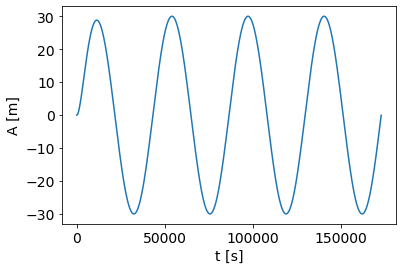

In [27]:
# Specify the runtime in seconds
runtime = 2*86400 # 3 days
ntout = 600//dt # how often to output the model solution

# Boundary condition parameters
a0 = 30.
period = 12*3600.

# Number of time steps to run
nsteps = int(runtime//dt)

# Plot up the boundary function
t = np.arange(0, nsteps*dt, dt)
plt.figure()

plt.plot(t, bcfunc(a0, period, t))
plt.ylabel('A [m]')
plt.xlabel('t [s]')

# Run the model...

In [28]:
t=[]
A=[]
mykdv.t=0
for ii in range(nsteps):
    if ii%ntout==0:
        # Store snapshots of the solution every "ntout" steps
        t.append(mykdv.t)
        A.append(mykdv.B_n_p1*1) # the solution is stored as the "B_n_p1" 
        
    if mykdv.solve_step(bc_left=bcfunc(a0,period,mykdv.t)) != 0:
        print('Blowing up at step: %d'%ii)
        break
        

        
t = np.array(t)
A = np.array(A)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


Text(0.5, 0, 'x [m]')

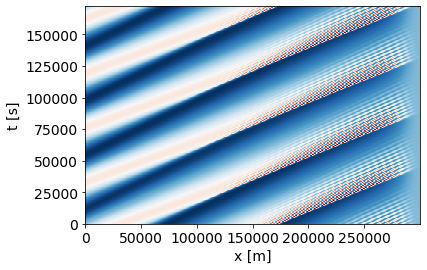

In [29]:
#"x-t"/Hovmoller plot of the solution

plt.figure()
plt.pcolormesh(x, t, A, cmap='RdBu')
plt.ylabel('t [s]')
plt.xlabel('x [m]')


In [30]:
# Animate the solution
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

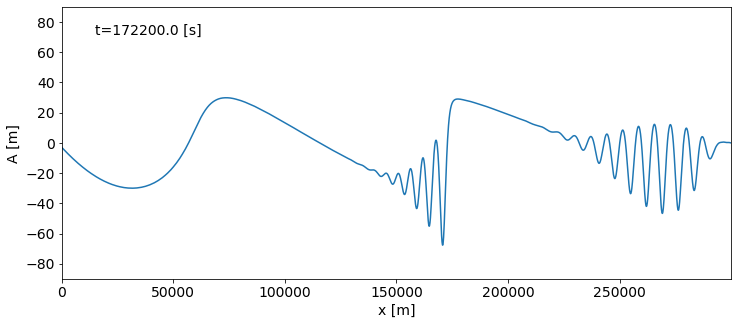

In [31]:
tstep = 0

fig=plt.figure(figsize=(12,5))
ax=plt.subplot(111)
ll, = ax.plot(x, A[tstep,:])
plt.xlim(x[0],x[-1])
plt.ylabel('A [m]')
plt.xlabel('x [m]')
txt= plt.text(0.05, 0.9, "t={} [s]".format(tstep*mykdv.dt*ntout), transform=ax.transAxes)
plt.ylim(-3*a0, 3*a0)

def update(tstep):

        ll.set_ydata(A[tstep,:])
        txt.set_text("t={} [s]".format(tstep*mykdv.dt*ntout))
        
        return txt
    
anim = FuncAnimation(fig, update, frames=range(0, t.shape[0]))
anim.save('../FIGURES/vkdv_example_itf.gif', fps=24, dpi=90)

# HTML(anim.to_jshtml())